In [14]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random as rd
import datetime
from scipy import optimize 



from irrmc.irrmontecarlo import Asset, Fund, portfolioScaling, portfolioGenerator, portfolioValue, MC, multiMC,plotMC, portfolioMC, meanIRR, IRRMonteCarlo 

path = '/Downloads/market_data_V.xlsx'
xl = pd.ExcelFile(path)

dfs = {sheet_name: xl.parse(sheet_name) 
          for sheet_name in xl.sheet_names}

"dfs = pd.read_excel(file_name, sheet_name=None)"
print(xl.sheet_names)
df1 = xl.parse('Data_Values')
df1 = xl.parse('Data_Values')
xln = np.array(df1)
fe = df1.iloc[6:,0:3]
fe.columns = ['EURUSD', 'GBPUSD','EURGBP']
fe.head(3)
fe.iloc[69,0] = (fe.iloc[68,0] + fe.iloc[70,0])/2
fe.head(5)

eurusd = fe.iloc[:,0]
gbpusd = fe.iloc[:,1]
eurgbp = fe.iloc[:,2]



['Data', 'Tickers', 'Data_Values']


**Using Geometric Brownian Motion to model FX rates and IRR at risk using Monte Carlo simulation.**

We will use the daily return to derive mu and sigma in our GBM model.


In [209]:
eurON = df1.iloc[6:,78]
eur1Y = df1.iloc[6:,89]

gbpON = df1.iloc[6:,96]
gbp1Y = df1.iloc[6:,107]

I am using the daily returns in the last year so that the value we obtain is relevant, and doesn't include pricing history during periods which are not in-line with current market behaviour.

EWMA could be used here in future.

In [240]:
eurusd_mu = eurusd.iloc[:-252].pct_change().mean()
eurusd_sigma = eurusd.iloc[:-252].pct_change().std()

gbpusd_mu = gbpusd.iloc[:-252].pct_change().mean()
gbpusd_sigma = gbpusd.iloc[:-252].pct_change().std()

eurON_mu = eurON.iloc[:-252].mean()
eurON_sigma = eurON.iloc[:-252].std()

eur1Y_mu = eur1Y.iloc[:-252].mean()
eur1Y_sigma = eur1Y.iloc[:-252].std()

gbp1Y_mu = gbp1Y.iloc[:-252].mean()


In [238]:
print("eurusd_mu: " + str(eurusd_mu), 
      "eur1Y_mu: " + str(eur1Y_mu),
      "eurON_mu: " + str(eurON_mu),
     "eurusd_sigma: " + str(eurusd_sigma),
     "eur1Y_sigma: " + str(eur1Y_sigma),
     "eurON_sigma: " + str(eurON_sigma))

eurusd_mu: 5.5129580721411246e-05 eur1Y_mu: 10.528904712041879 eurON_mu: 11.122094869109924 eurusd_sigma: 0.0062356828812554195 eur1Y_sigma: 2.505111935570326 eurON_sigma: 4.47066909885333


Here are the mu and sigma values for the daily return of the spot rates, and the 1Y Implied Volatility. I will use the daily returns for this GBM model for now.

For simplicity, I am using the fund model provided in our most recent email where a fund has 3 deals, in US, UK and EU with the initial investment on 6/12/2019, and subsequent cashflows at 12/31/2020, every year until 2023. This is so we can easily compare the provided IRR values.

In [194]:
cashflow1 = [-100000000,25000000,25000000,25000000,125000000]

The code below uses the GBM model, with mu equal to the mean daily return over the last year, and sigma equal to the standard deviation of daily returns over the last year. This model can also use the Implied Volatility of a 1Y contract.

We use the standard GBM formula (https://en.wikipedia.org/wiki/Geometric_Brownian_motion) to simulate the currency price.

In [227]:
def GBM(num_sims, num_years, currency, mu, sigma):

    returns = currency.pct_change()

    last_price = currency[-1]
    
    simulation_df = pd.DataFrame()
    
    
    for x in range(num_sims):
        price_series = []
        price = last_price * np.exp((mu - (sigma**2/2)) + sigma * np.random.normal())
        price_series.append(price)
        for year in range(num_years):
            if(year == 0):
                for day in range(251):
                    next_day = price_series[-1] * np.exp((mu - ((sigma**2)/2)) + sigma * np.random.normal())
                    price_series.append(next_day)
            else:
                for day in range(252):
                    next_day = price_series[-1] * np.exp((mu - ((sigma**2)/2)) + sigma * np.random.normal())
                    price_series.append(next_day)
                    
        simulation_df[x] = price_series

        
    return simulation_df


    
eursim_df = GBM(1000, 4, eurusd, eurusd_mu, eurusd_sigma)   
gbpsim_df = GBM(1000, 4, gbpusd, gbpusd_mu, gbpusd_sigma)


We can plot the simulation results below. The red line is the initial value of the FX rate.

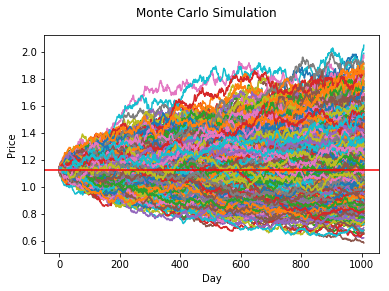

In [201]:
def plotGBM(currency_series, num_sims, mu, sigma):
    
    sim_df = GBM(num_sims, 4, currency_series, mu, sigma)

    fig = plt.figure() 
    fig.suptitle('Monte Carlo Simulation')
    plt.plot(sim_df)
    plt.axhline(y = currency_series[-1], color = 'r', linestyle = '-')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.show()
    
    return


plotGBM(eurusd, 1000, eurusd_mu, eurusd_sigma)


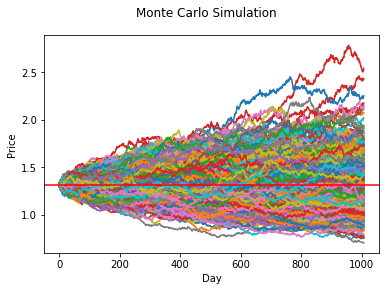

In [202]:
plotGBM(gbpusd, 1000, gbpusd_mu, gbpusd_sigma)

This function finds the simulated rate at yearly intervals.

In [183]:
def findValues(simulation_df, currency, cashflow):
    
    initial_price = currency[-1]
    currency_df = pd.DataFrame()
    
    for column in range(simulation_df.shape[1]):
        price0 = initial_price * cashflow[0]
        price1 = simulation_df.iloc[251,column] * cashflow[1]
        price2 = simulation_df.iloc[252*2-1,column] * cashflow[2]
        price3 = simulation_df.iloc[252*3-1,column] * cashflow[3]
        price4 = simulation_df.iloc[252*4-1,column] * cashflow[4]
        currency_df[column] = [price0,price1, price2, price3, price4]
        
    return currency_df

eur_val = findValues(eursim_df, eurusd, cashflow1)
gbp_val = findValues(gbpsim_df, gbpusd, cashflow1)

The code below takes the monte carlo simulation generated rates and generates the simulated cash flows for each year.

In [184]:
def findFundCF(simulation_df1, simulation_df2, currency1, currency2, cashflow):
    
    initial_price1 = currency1[-1]
    initial_price2 = currency2[-1]
    currency_df1 = pd.DataFrame()
    currency_df2 = pd.DataFrame()
    currency_df = pd.DataFrame()
    
    for column in range(simulation_df1.shape[1]):
        price0 = initial_price1 * cashflow[0]
        price1 = simulation_df1.iloc[251,column] * cashflow[1]
        price2 = simulation_df1.iloc[252*2-1,column] * cashflow[2]
        price3 = simulation_df1.iloc[252*3-1,column] * cashflow[3]
        price4 = simulation_df1.iloc[252*4-1,column] * cashflow[4]
        currency_df1[column] = [price0,price1, price2, price3, price4]
        
    for column in range(simulation_df2.shape[1]):
        price0 = initial_price2 * cashflow[0] + cashflow[0]
        price1 = simulation_df2.iloc[251,column] * cashflow[1] + cashflow[1]
        price2 = simulation_df2.iloc[252*2-1,column] * cashflow[2] + cashflow[2]
        price3 = simulation_df2.iloc[252*3-1,column] * cashflow[3] + cashflow[3]
        price4 = simulation_df2.iloc[252*4-1,column] * cashflow[4] + cashflow[4]
        currency_df2[column] = [price0,price1, price2, price3, price4]
        
        
        
    currency_df = currency_df1 + currency_df2
 
        
    return currency_df
  
    
fund1 = findFundCF(eursim_df, gbpsim_df, eurusd, gbpusd, cashflow1)  

The initial value is the same for each simulation as we start each Monte Carlo simulation from the same rates.

(-3.43580 * 100,000,000)

In [185]:
fund1

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,...,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08,-3.435800e+08
1,8.843762e+07,8.496200e+07,8.550463e+07,8.538523e+07,8.172182e+07,8.066492e+07,8.297143e+07,8.723420e+07,8.017868e+07,8.679976e+07,...,8.937933e+07,8.816334e+07,8.772001e+07,8.629256e+07,8.201654e+07,8.297369e+07,8.050308e+07,7.636910e+07,8.427769e+07,8.700692e+07
2,9.317654e+07,9.446897e+07,8.006948e+07,8.792410e+07,8.103073e+07,8.192349e+07,7.683504e+07,8.705380e+07,8.580150e+07,8.561441e+07,...,8.910452e+07,9.028130e+07,8.181909e+07,9.152958e+07,7.665802e+07,8.124507e+07,8.284829e+07,7.514335e+07,8.478349e+07,8.636347e+07
3,8.598057e+07,9.750981e+07,7.715202e+07,9.415018e+07,7.759321e+07,8.116782e+07,7.467228e+07,9.365415e+07,8.347918e+07,8.182674e+07,...,8.650904e+07,8.388543e+07,8.826309e+07,8.429615e+07,7.822259e+07,8.306371e+07,7.845469e+07,7.566401e+07,8.447082e+07,8.114280e+07
4,4.381422e+08,5.124202e+08,3.703596e+08,4.950017e+08,3.849900e+08,4.301944e+08,4.122462e+08,4.598882e+08,4.483805e+08,4.029791e+08,...,4.809225e+08,4.016439e+08,4.732125e+08,4.390657e+08,4.089323e+08,4.554896e+08,3.879359e+08,3.715935e+08,4.462287e+08,3.906454e+08


The following code solves NPV and IRR for multi-period cash flows using the optimize library.

In [187]:
def secant_method(tol, f, x0):
    x1 = x0*1.1
    while (abs(x1-x0)/abs(x1) > tol):
        x0, x1 = x1, x1-f(x1)*(x1-x0)/(f(x1)-f(x0))
    return x1

def xnpv(rate,cashflows):

    chron_order = sorted(cashflows, key = lambda x: x[0])
    t0 = chron_order[0][0] #t0 is the date of the first cash flow

    return sum([cf/(1+rate)**((t-t0).days/365.0) for (t,cf) in chron_order])

def xirr(cashflows,guess=0.1):
    
    #return secant_method(0.0001,lambda r: xnpv(r,cashflows),guess)
    return optimize.newton(lambda r: xnpv(r,cashflows),guess)

Our initial IRR using the current (initial) spot - as on the example excel sheet is 20.8%

In [188]:
cash = [(datetime.date(2019, 6, 19),-338),(datetime.date(2020, 12, 31),84.5),(datetime.date(2021, 12, 31), 84.5),(datetime.date(2022, 12, 31), 84.5), 
((datetime.date(2023, 12, 31), 422.5))] 
 
    
initial_irr = xirr(cash)
initial_irr
 


0.2080925027727066

The following function irrCalc calculates the IRR for each simulated rate and appends them into a list.

In [228]:
def irrCalc(df):
    
    irr = []
    
    for column in range(df.shape[1]):
        cash = [(datetime.date(2019, 6, 19),df.iloc[0,column]),
                (datetime.date(2020, 12, 31),df.iloc[1,column]),
                (datetime.date(2021, 12, 31), df.iloc[2,column]),
                (datetime.date(2022, 12, 31), df.iloc[3,column]), 
                ((datetime.date(2023, 12, 31), df.iloc[4,column]))] 
        
        irr.append(xirr(cash))
        
    return irr


In [190]:
sim_irr = irrCalc(fund1)

sim_irr[:10]

[0.21810721615378478,
 0.2508347332172087,
 0.1731789001633852,
 0.23922981527214127,
 0.17798668895108974,
 0.19967004327912583,
 0.1870283384866006,
 0.22613141873119122,
 0.21048722202713674,
 0.19507102938534077]

Next we calculate the IRR at risk by subtracting the initial IRR from our simulated values.

In [191]:
rr_risk = []

for i in sim_irr:
    
    a = initial_irr - i
    
    irr_risk.append(a)
    
irr_risk[:10]



[0.019097796487244828,
 -0.02683952976096307,
 0.0020015793462127285,
 0.012519325067555098,
 0.02241373759302484,
 -0.0009639038799686694,
 0.012593139970362932,
 -0.0013393017313741984,
 -0.014708357299017621,
 0.03765717689734038]

Now we calculate the IRR at risk and take the 5th percentile (95% confidence level).

In [192]:
irr_95c = np.percentile(irr_risk,5)
irr_95c


-0.04553140375087556

Hence our 95% confidence IRR at risk is:

In [233]:
print ("{0:.3%}".format(irr_95c))

-4.553%


This seems like a sensible value and is inline with my expectations of this model as the 95% confidence level value for IRR at risk. This value represents the IRR at risk over a 4 year period due to FX risk and is the difference of the projected IRR using the current spot rates, and the IRR generated from our simulated spot rates. 



Furthermore, the mean value of the IRR at risk is just below 0.

In [255]:
print ("{0:.3%}".format(np.mean(irr_risk)))

-0.212%


Our simulated worst case IRR at risk is:

In [236]:
a = min(irr_risk)
print ("{0:.3%}".format(a))

-9.770%


I used the daily returns in the GBM model as this is the most common route in the literature surrounding modelling asset prices using GBM. I am aware that the Implied Volatility can be used as an input to the model to yield more accurate prices.